In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, add, BatchNormalization, Activation
import os
import glob
import tifffile as tiff
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
import rasterio
from sklearn.model_selection import train_test_split;
import re
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
def conv_block(x, filters, batchnorm=True):
    conv1 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv2 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation("relu")(conv2)

    return conv2

In [14]:
def residual_conv_block(x, filters, batchnorm=True):
    conv1 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv2 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation("relu")(conv2)
        
    #skip connection    
    shortcut = Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = BatchNormalization(axis=3)(shortcut)
    shortcut = Activation("relu")(shortcut)
    respath = add([shortcut, conv2])       
    return respath

In [15]:
def dense_block(inputs, num_filters):
    conv1 = conv_block(inputs, num_filters)
    concat = Concatenate()([inputs, conv1])
    return concat

In [16]:
def residual_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = residual_conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = residual_conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = residual_conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = residual_conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), kernel_initializer='he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = Concatenate()([up6, conv4])
    conv6 = residual_conv_block(up6, 512)
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = Concatenate()([up7, conv3])
    conv7 = residual_conv_block(up7, 256)
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = Concatenate()([up8, conv2])
    conv8 = residual_conv_block(up8, 128)
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = Concatenate()([up9, conv1])
    conv9 = residual_conv_block(up9, 64)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
def dense_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = dense_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = dense_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = dense_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = dense_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), kernel_initializer='he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = Concatenate()([up6, conv4])
    conv6 = residual_conv_block(up6, 512)
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = Concatenate()([up7, conv3])
    conv7 = residual_conv_block(up7, 256)
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = Concatenate()([up8, conv2])
    conv8 = residual_conv_block(up8, 128)
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = Concatenate()([up9, conv1])
    conv9 = residual_conv_block(up9, 64)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
def load_data(input_dir, mask_dir):
    def numerical_sort(value):
        numbers = re.findall(r'\d+', os.path.basename(value))
        return int(numbers[-1]) if numbers else -1

    # Ensure the directories exist
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist.")
        return None, None
    
    if not os.path.exists(mask_dir):
        print(f"Mask directory {mask_dir} does not exist.")
        return None, None

    # Search for .tif files in the directories and sort them numerically
    input_files = sorted(glob.glob(os.path.join(input_dir, '*.tif')), key=numerical_sort)
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')), key=numerical_sort)

    print("Found input files:", input_files)
    print("Found mask files:", mask_files)

    if not input_files:
        print(f"No input files found in {input_dir}.")
        return None, None

    if not mask_files:
        print(f"No mask files found in {mask_dir}.")
        return None, None

    images = []
    masks = []

    for input_file, mask_file in zip(input_files, mask_files):
        # Read input file
        with rasterio.open(input_file) as src:
            img = src.read(1)  # Read the first band assuming it's a single-band image
            # print(f"Reading image from {input_file}")
            images.append(img)

        # Read mask file
        with rasterio.open(mask_file) as src:
            msk = src.read(1)  # Read the first band assuming it's a single-band image
            # print(msk)
            masks.append(msk)

    return np.array(images), np.array(masks)


In [19]:
def load_data_new(input_dir, mask_dir):
    
    def numerical_sort(value):
        numbers = re.findall(r'\d+', os.path.basename(value))
        return int(numbers[-1]) if numbers else -1

    # Ensure the directories exist
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist.")
        return None, None
    
    if not os.path.exists(mask_dir):
        print(f"Mask directory {mask_dir} does not exist.")
        return None, None

    # Search for .tif files in the directories
    input_files = glob.glob(os.path.join(input_dir, '*.tif'))
    mask_files = glob.glob(os.path.join(mask_dir, '*.tif'))

    print("Found input files:", input_files)
    print("Found mask files:", mask_files)

    if not input_files:
        print(f"No input files found in {input_dir}.")
        return None, None

    if not mask_files:
        print(f"No mask files found in {mask_dir}.")
        return None, None

    images = []
    masks = []

    for mask_file in mask_files:
        # Extract the number i from the mask filename
        match = re.search(r'NDWI_Mask_(\d+)_resized1_corrupt.tif', os.path.basename(mask_file))
        if match:
            i = match.group(1)
            input_file = os.path.join(input_dir, f'{i}.tif')
            
            # Check if the corresponding input file exists
            if os.path.exists(input_file):
                # Read input file
                with rasterio.open(input_file) as src:
                    img = src.read(1)  # Read the first band assuming it's a single-band image
                    images.append(img)

                # Read mask file
                with rasterio.open(mask_file) as src:
                    msk = src.read(1)  # Read the first band assuming it's a single-band image
                    masks.append(msk)
            else:
                print(f"Corresponding input file {input_file} for mask {mask_file} not found.")

    if not images or not masks:
        print("No matching pairs of images and masks found.")
        return None, None

    return np.array(images), np.array(masks)

In [20]:
# def load_data_test_new(input_dir, mask_dir):
    
#     def numerical_sort(value):
#         numbers = re.findall(r'\d+', os.path.basename(value))
#         return int(numbers[-1]) if numbers else -1

#     # Ensure the directories exist
#     if not os.path.exists(input_dir):
#         print(f"Input directory {input_dir} does not exist.")
#         return None, None
    
#     if not os.path.exists(mask_dir):
#         print(f"Mask directory {mask_dir} does not exist.")
#         return None, None

#     # Search for .tif files in the directories
#     input_files = glob.glob(os.path.join(input_dir, '*.tif'))
#     mask_files = glob.glob(os.path.join(mask_dir, '*.tif'))

#     print("Found input files:", input_files)
#     print("Found mask files:", mask_files)

#     if not input_files:
#         print(f"No input files found in {input_dir}.")
#         return None, None

#     if not mask_files:
#         print(f"No mask files found in {mask_dir}.")
#         return None, None

#     images = []
#     masks = []

#     for mask_file in mask_files:
#         # Extract the number i from the mask filename
#         match = re.search(r'NDWI_Mask_(\d+)_resized_corrupt.tif', os.path.basename(mask_file))
#         if match:
#             i = match.group(1)
#             input_file = os.path.join(input_dir, f'{i}.tif')
            
#             # Check if the corresponding input file exists
#             if os.path.exists(input_file):
#                 # Read input file
#                 with rasterio.open(input_file) as src:
#                     img = src.read(1)  # Read the first band assuming it's a single-band image
#                     images.append(img)

#                 # Read mask file
#                 with rasterio.open(mask_file) as src:
#                     msk = src.read(1)  # Read the first band assuming it's a single-band image
#                     masks.append(msk)
#             else:
#                 print(f"Corresponding input file {input_file} for mask {mask_file} not found.")

#     if not images or not masks:
#         print("No matching pairs of images and masks found.")
#         return None, None

#     return np.array(images), np.array(masks)

In [21]:
def load_data_test(input_dir, mask_dir):
    
    def numerical_sort(value):
        numbers = re.findall(r'\d+', os.path.basename(value))
        return int(numbers[-1]) if numbers else -1

    # Ensure the directories exist
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist.")
        return None, None
    
    if not os.path.exists(mask_dir):
        print(f"Mask directory {mask_dir} does not exist.")
        return None, None

    # Search for .tif files in the directories
    input_files = glob.glob(os.path.join(input_dir, '*.tif'))
    mask_files = glob.glob(os.path.join(mask_dir, '*.tif'))

    print("Found input files:", input_files)
    print("Found mask files:", mask_files)

    if not input_files:
        print(f"No input files found in {input_dir}.")
        return None, None

    if not mask_files:
        print(f"No mask files found in {mask_dir}.")
        return None, None

    images = []
    masks = []

    for mask_file in mask_files:
        # Extract the number i from the mask filename
        match = re.search(r'NDWI_Mask_(\d+)_resized.tif', os.path.basename(mask_file))
        if match:
            i = match.group(1)
            input_file = os.path.join(input_dir, f'{i}.tif')
            
            # Check if the corresponding input file exists
            if os.path.exists(input_file):
                # Read input file
                with rasterio.open(input_file) as src:
                    img = src.read(1)  # Read the first band assuming it's a single-band image
                    images.append(img)

                # Read mask file
                with rasterio.open(mask_file) as src:
                    msk = src.read(1)  # Read the first band assuming it's a single-band image
                    masks.append(msk)
            else:
                print(f"Corresponding input file {input_file} for mask {mask_file} not found.")

    if not images or not masks:
        print("No matching pairs of images and masks found.")
        return None, None

    return np.array(images), np.array(masks)

In [22]:
# def load_data1(input_dir, mask_dir):
#     # Ensure the directories exist
#     if not os.path.exists(input_dir):
#         print(f"Input directory {input_dir} does not exist.")
#         return None, None
    
#     if not os.path.exists(mask_dir):
#         print(f"Mask directory {mask_dir} does not exist.")
#         return None, None

#     # Print the contents of the directories
#     print("Input directory contents:", os.listdir(input_dir))
#     print("Mask directory contents:", os.listdir(mask_dir))

#     # Search for .tif files in the directories
#     input_files = sorted(glob.glob(os.path.join(input_dir, '*.tif')))
#     mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

#     print("Found input files:", input_files)
#     print("Found mask files:", mask_files)

#     if not input_files:
#         print(f"No input files found in {input_dir}.")
#         return None, None

#     if not mask_files:
#         print(f"No mask files found in {mask_dir}.")
#         return None, None

#     images = []
#     masks = []

#     for input_file, mask_file in zip(input_files, mask_files):
#         # Read input file
#         with rasterio.open(input_file) as src:
#             img = src.read(1)  # Read the first band assuming it's a single-band image
#             print(f"Reading image from {input_file}")
#             images.append(img)

#         # Read mask file
#         with rasterio.open(mask_file) as src:
#             msk = src.read(1)  # Read the first band assuming it's a single-band image
#             masks.append(msk)

    # return np.array(images), np.array(masks) / 255

In [23]:
def load_data_png(input_dir, mask_dir):
    input_files = sorted(glob.glob(os.path.join(input_dir, '*.png')))
    # print(input_files)
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
    # print(mask_files)
    images = []
    masks = []

    for input_file, mask_file in zip(input_files, mask_files):

        image = cv2.imread(input_file)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(np.array(image_rgb))

        image = cv2.imread(mask_file)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        masks.append(np.array(image_rgb))

    # print(np.array(masks)/255)
    return np.array(images), np.array(masks)/255

In [24]:
def predict(model, images, masks, output_dir, model_type, number=-1):

    i=0
    for arbitrary_img, arbitrary_mask in zip(images, masks):

    # arbitrary_image_path = 'data_new\subset_0_of_subset_1_of_final_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_0_1024.tif'
    # arbitrary_image_mask = 'output_tif\subset_0_of_subset_1_of_final_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_0_1024_new_mask.tif'

    # # Read the arbitrary image
    # with rasterio.open(arbitrary_image_path) as src:
    #     arbitrary_img = src.read(1)  # Read the first band assuming it's a single-band image

    # with rasterio.open(arbitrary_image_mask) as src:
    #     arbitrary_mask = src.read(1)

    # Preprocess the arbitrary image if necessary (e.g., normalize, resize) to match the input dimensions of your model
    # ...

        predicted_mask = model.predict(np.expand_dims(arbitrary_img, axis=0))[0]

        # Plot the arbitrary image and the predicted mask
        plt.figure(figsize=(10, 5))

        plt.subplot(2, 2, 1)
        plt.imshow(arbitrary_img, cmap='gray')
        plt.title('Arbitrary Image')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        # print(arbitrary_mask)
        print(np.min(arbitrary_mask))
        print(np.max(arbitrary_mask))
        plt.imshow(arbitrary_mask, cmap='gray')
        plt.title('Actual Mask')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(predicted_mask, cmap='gray')
        print("Predicted_Mask")
        print("Min value in predicted_mask:", np.min(predicted_mask))
        print("Max value in predicted_mask:", np.max(predicted_mask))
        plt.title('Predicted Mask without thresholding')
        plt.axis('off')

         # 
         #hold the predicted mask if necessary
        predicted_mask = (predicted_mask > 0.70).astype(np.uint8)

        plt.subplot(2, 2, 4)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.savefig(f"./{output_dir}/{model_type}_{i}.jpg")
        plt.close()
        i+=1
        # break
        if (i==number):
            break

In [25]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def save_image(image, filepath):
    image = (image * 255).astype(np.uint8)  # Scale image to 0-255
    tiff.imwrite(filepath, image)

def predict1(model, mask_dir, image_dir, output_dir, model_type, number=-1):
    dice_scores = []
    iou_scores = []
    precisions = []
    recalls = []
    f1_scores = []

    os.makedirs(output_dir, exist_ok=True)

    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('_resized.tif')]
    i = 0
    print(len(mask_files))
    for mask_file in mask_files:
        # try:
        # Extract the number i from the mask file name
        print(mask_file)
        i_str = mask_file.split('_')[2]
        print(i_str)
        image_file = f"{i_str}.tif"

        mask_path = os.path.join(mask_dir, mask_file)
        image_path=os.path.join(image_dir, image_file)
        print(image_path)

        # Load the image and mask
        arbitrary_img = tiff.imread(image_path)
        arbitrary_mask = tiff.imread(mask_path)

        # Ensure the image is in the correct shape (512, 512, 1)
        if len(arbitrary_img.shape) == 2:
            arbitrary_img = np.expand_dims(arbitrary_img, axis=-1)
        elif arbitrary_img.shape[0] == 2:
            arbitrary_img = arbitrary_img[0]  # assuming you need the first channel
        
        predicted_mask = model.predict(np.expand_dims(arbitrary_img, axis=0))[0]

        # Apply thresholding to predicted mask
        predicted_mask_thresh = (predicted_mask > 0.37).astype(np.uint8)

        # Save predicted mask images
        save_image(predicted_mask, f"./{output_dir}/{model_type}_Predicted_Image_{i_str}.tif")
        save_image(predicted_mask_thresh, f"./{output_dir}/{model_type}_{i_str}.tif")

        # Plot and save the arbitrary image, actual mask, and predicted mask
        plt.figure(figsize=(10, 5))

        plt.subplot(2, 2, 1)
        plt.imshow(arbitrary_img.squeeze(), cmap='gray')
        plt.title('Arbitrary Image')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(arbitrary_mask, cmap='gray')
        plt.title('Actual Mask')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask without thresholding')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(predicted_mask_thresh.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.savefig(f"./{output_dir}/{model_type}_Visualization_{i_str}.jpg")
        plt.close()

        # Calculate metrics
        dice = dice_coefficient(arbitrary_mask, predicted_mask_thresh)
        iou_score = iou(arbitrary_mask, predicted_mask_thresh)
        precision = precision_score(arbitrary_mask.flatten(), predicted_mask_thresh.flatten())
        recall = recall_score(arbitrary_mask.flatten(), predicted_mask_thresh.flatten())
        f1 = f1_score(arbitrary_mask.flatten(), predicted_mask_thresh.flatten())

        dice_scores.append(dice)
        iou_scores.append(iou_score)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
        i += 1
        if i == number:
            break
    # Print and return the average metrics
    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1 = np.mean(f1_scores)

    print(f"Mean Dice Coefficient: {mean_dice}")
    print(f"Mean IoU: {mean_iou}")
    print(f"Mean Precision: {mean_precision}")
    print(f"Mean Recall: {mean_recall}")
    print(f"Mean F1 Score: {mean_f1}")

    return mean_dice, mean_iou, mean_precision, mean_recall, mean_f1

In [32]:
input_dir = './data_new/'
mask_dir = './GEE_Masks/GEE_resized/train_gee'
output_dir = './GEE_Output/Adversarial/Average'

# Load data
images, masks = load_data_new(input_dir, mask_dir)

# Define input shape and number of classes
images = np.expand_dims(images, axis=-1)
input_shape = images.shape[1:]

# images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create and compile the model

# for layer in model.layers:
#     print(layer.output_shape)


c:\Users\ADMIN\anaconda3\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Found input files: ['./data_new\\0_0.tif', './data_new\\1.tif', './data_new\\10.tif', './data_new\\100.tif', './data_new\\1000.tif', './data_new\\1001.tif', './data_new\\1002.tif', './data_new\\1003.tif', './data_new\\1004.tif', './data_new\\1005.tif', './data_new\\1006.tif', './data_new\\1007.tif', './data_new\\1008.tif', './data_new\\1009.tif', './data_new\\101.tif', './data_new\\1010.tif', './data_new\\1011.tif', './data_new\\1012.tif', './data_new\\1013.tif', './data_new\\1014.tif', './data_new\\1015.tif', './data_new\\1016.tif', './data_new\\1017.tif', './data_new\\1018.tif', './data_new\\1019.tif', './data_new\\102.tif', './data_new\\1020.tif', './data_new\\1021.tif', './data_new\\1022.tif', './data_new\\1023.tif', './data_new\\1024.tif', './data_new\\1025.tif', './data_new\\1026.tif', './data_new\\1027.tif', './data_new\\1028.tif', './data_new\\1029.tif', './data_new\\103.tif', './data_new\\1030.tif', './data_new\\1031.tif', './data_new\\1032.tif', './data_new\\1033.tif', './dat

In [33]:
input_shape = images.shape[1:]
print(input_shape)
print(len(images))

(512, 512, 1)
630


In [34]:
model = dense_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
model.fit(images, masks, validation_split=0.1, epochs=10, batch_size=2)  # Adjust epochs and batch size as needed


Epoch 1/10
284/284 [==============================] - 154s 537ms/step - loss: 0.6567 - accuracy: 0.6548 - val_loss: 1.2712 - val_accuracy: 0.3634
Epoch 2/10
284/284 [==============================] - 156s 549ms/step - loss: 0.6337 - accuracy: 0.6774 - val_loss: 0.7146 - val_accuracy: 0.6579
Epoch 3/10
284/284 [==============================] - 156s 548ms/step - loss: 0.6275 - accuracy: 0.6800 - val_loss: 0.6343 - val_accuracy: 0.6600
Epoch 4/10
284/284 [==============================] - 156s 550ms/step - loss: 0.6277 - accuracy: 0.6819 - val_loss: 0.6191 - val_accuracy: 0.6896
Epoch 5/10
284/284 [==============================] - 156s 549ms/step - loss: 0.6285 - accuracy: 0.6805 - val_loss: 0.6135 - val_accuracy: 0.6913
Epoch 6/10
284/284 [==============================] - 156s 549ms/step - loss: 0.6257 - accuracy: 0.6832 - val_loss: 0.6450 - val_accuracy: 0.6824
Epoch 7/10
284/284 [==============================] - 156s 548ms/step - loss: 0.6305 - accuracy: 0.6749 - val_loss: 0.6141 -

In [35]:

model.save('UNet_dense_GEE_adversarial_average_10_new_epoch')

INFO:tensorflow:Assets written to: UNet_dense_GEE_adversarial_average_10_new_epoch\assets


INFO:tensorflow:Assets written to: UNet_dense_GEE_adversarial_average_10_new_epoch\assets


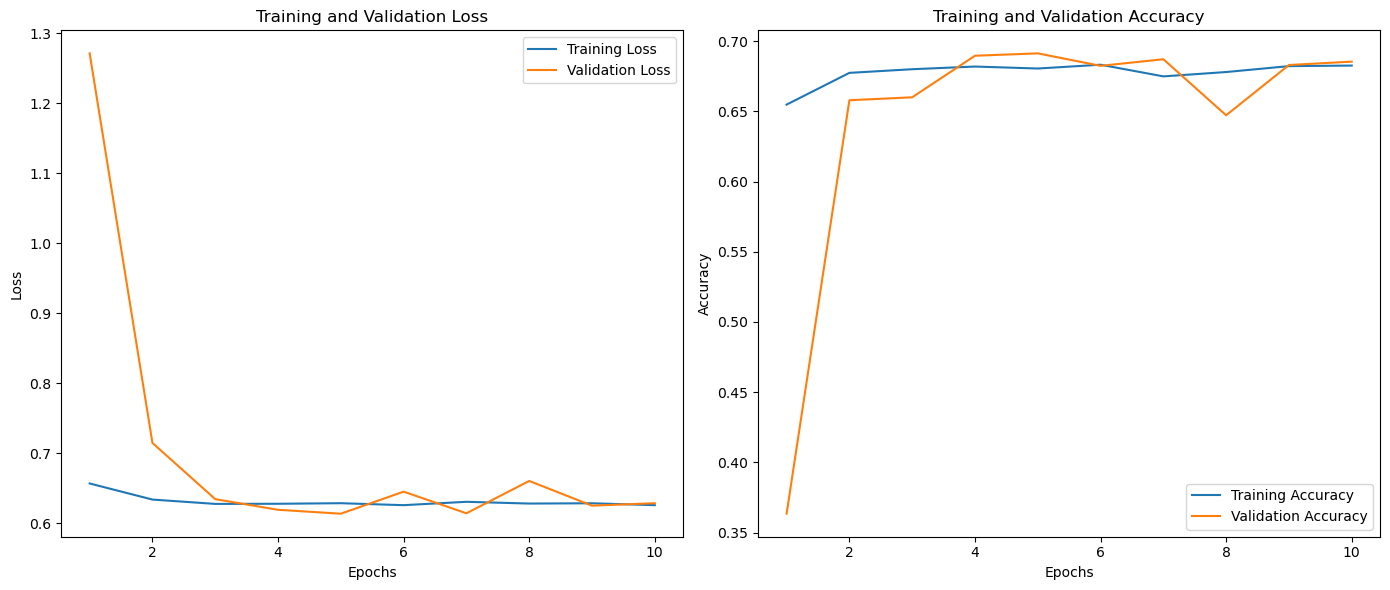

In [36]:
import matplotlib.pyplot as plt

# Data from the model training output
epochs = range(1, 11)
train_loss = [0.6567, 0.6337, 0.6275, 0.6277, 0.6285, 0.6257, 0.6305, 0.6280, 0.6284, 0.6257]
val_loss = [1.2712, 0.7146, 0.6343, 0.6191, 0.6135, 0.6450, 0.6141, 0.6603, 0.6250, 0.6285]
train_accuracy = [0.6548, 0.6774, 0.6800, 0.6819, 0.6805, 0.6832, 0.6749, 0.6780, 0.6822, 0.6826]
val_accuracy = [0.3634, 0.6579, 0.6600, 0.6896, 0.6913, 0.6824, 0.6871, 0.6472, 0.6830, 0.6854]

# Plotting the training and validation loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [37]:
# %%capture
# model = load_model('UNet_dense_10_epoch.h5')
# predict1(model, images, masks, output_dir, 'dense')

# import h5p
input_dir = './data_new/'
mask_dir = './GEE_Masks/GEE_resized/test_gee/'
output_dir = './GEE_Output/Adversarial/Average'

# Load data
# images, masks = load_data_test(input_dir, mask_dir)

# model = load_model()



In [38]:
model = tf.keras.models.load_model('UNet_dense_GEE_adversarial_average_10_new_epoch', compile=False)
model.compile()
predict1(model,mask_dir,input_dir, output_dir, 'dense')

632
NDWI_Mask_1000_resized.tif
1000
./data_new/1000.tif
1/1 [==============================] - 0s 302ms/step
NDWI_Mask_1001_resized.tif
1001
./data_new/1001.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1002_resized.tif
1002
./data_new/1002.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1004_resized.tif
1004
./data_new/1004.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1005_resized.tif
1005
./data_new/1005.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1007_resized.tif
1007
./data_new/1007.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1008_resized.tif
1008
./data_new/1008.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_100_resized.tif
100
./data_new/100.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1010_resized.tif
1010
./data_new/1010.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1011_resized.tif
1011
./data_new/1011.tif
1/1 [=====

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1081_resized.tif
1081
./data_new/1081.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1082_resized.tif
1082
./data_new/1082.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1086_resized.tif
1086
./data_new/1086.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1087_resized.tif
1087
./data_new/1087.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1089_resized.tif
1089
./data_new/1089.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_108_resized.tif
108
./data_new/108.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1090_resized.tif
1090
./data_new/1090.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1091_resized.tif
1091
./data_new/1091.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1092_resized.tif
1092
./data_new/1092.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1097_resized.tif
1097
./data_new/1097.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1099_resized.tif
1099
./data_new/1099.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_109_resized.tif
109
./data_new/109.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_10_resized.tif
10
./data_new/10.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1100_resized.tif
1100
./data_new/1100.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1101_resized.tif
1101
./data_new/1101.tif
1/1 [==============================] - 0s 19ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1102_resized.tif
1102
./data_new/1102.tif
1/1 [==============================] - 0s 22ms/step
NDWI_Mask_1104_resized.tif
1104
./data_new/1104.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1105_resized.tif
1105
./data_new/1105.tif
1/1 [==============================] - 0s 19ms/step
NDWI_Mask_1106_resized.tif
1106
./data_new/1106.tif
1/1 [==============================] - 0s 18ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1107_resized.tif
1107
./data_new/1107.tif
1/1 [==============================] - 0s 18ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1108_resized.tif
1108
./data_new/1108.tif
1/1 [==============================] - 0s 19ms/step
NDWI_Mask_1109_resized.tif
1109
./data_new/1109.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_110_resized.tif
110
./data_new/110.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1110_resized.tif
1110
./data_new/1110.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1112_resized.tif
1112
./data_new/1112.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1113_resized.tif
1113
./data_new/1113.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1114_resized.tif
1114
./data_new/1114.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1115_resized.tif
1115
./data_new/1115.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1118_resized.tif
1118
./data_new/1118.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1121_resized.tif
1121
./data_new/1121.tif
1/1 [==========

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_112_resized.tif
112
./data_new/112.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1130_resized.tif
1130
./data_new/1130.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1131_resized.tif
1131
./data_new/1131.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1133_resized.tif
1133
./data_new/1133.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1134_resized.tif
1134
./data_new/1134.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1135_resized.tif
1135
./data_new/1135.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1136_resized.tif
1136
./data_new/1136.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1137_resized.tif
1137
./data_new/1137.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_1138_resized.tif
1138
./data_new/1138.tif
1/1 [==============================] - 0s 21ms/step
NDWI_Mask_1139_resized.tif
1139
./data_new/1139.tif
1/1 [==========

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1200_resized.tif
1200
./data_new/1200.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1201_resized.tif
1201
./data_new/1201.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1203_resized.tif
1203
./data_new/1203.tif
1/1 [==============================] - 0s 19ms/step
NDWI_Mask_1204_resized.tif
1204
./data_new/1204.tif
1/1 [==============================] - 0s 19ms/step
NDWI_Mask_1206_resized.tif
1206
./data_new/1206.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1208_resized.tif
1208
./data_new/1208.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1209_resized.tif
1209
./data_new/1209.tif
1/1 [==============================] - 0s 18ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1211_resized.tif
1211
./data_new/1211.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1220_resized.tif
1220
./data_new/1220.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1223_resized.tif
1223
./data_new/1223.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1224_resized.tif
1224
./data_new/1224.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1226_resized.tif
1226
./data_new/1226.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1229_resized.tif
1229
./data_new/1229.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_122_resized.tif
122
./data_new/122.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1235_resized.tif
1235
./data_new/1235.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1236_resized.tif
1236
./data_new/1236.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1240_resized.tif
1240
./data_new/1240.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1241_resized.tif
1241
./data_new/1241.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1243_resized.tif
1243
./data_new/1243.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1244_resized.tif
1244
./data_new/1244.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1246_resized.tif
1246
./data_new/1246.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1247_resized.tif
1247
./data_new/1247.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1248_resized.tif
1248
./data_new/1248.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1249_resized.tif
1249
./data_new/1249.tif
1/1 [=======

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_286_resized.tif
286
./data_new/286.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_289_resized.tif
289
./data_new/289.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_28_resized.tif
28
./data_new/28.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_290_resized.tif
290
./data_new/290.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_292_resized.tif
292
./data_new/292.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_299_resized.tif
299
./data_new/299.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_29_resized.tif
29
./data_new/29.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_2_resized.tif
2
./data_new/2.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_300_resized.tif
300
./data_new/300.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_301_resized.tif
301
./data_new/301.tif
1/1 [==============================] - 0s 17ms/step
ND

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_425_resized.tif
425
./data_new/425.tif
1/1 [==============================] - 0s 18ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_426_resized.tif
426
./data_new/426.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_429_resized.tif
429
./data_new/429.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_42_resized.tif
42
./data_new/42.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_432_resized.tif
432
./data_new/432.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_434_resized.tif
434
./data_new/434.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_435_resized.tif
435
./data_new/435.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_436_resized.tif
436
./data_new/436.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_440_resized.tif
440
./data_new/440.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_443_resized.tif
443
./data_new/443.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_445_resized.tif
445
./data_new/445.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_448_resized.tif
448
./data_new/448.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_450_resized.tif
450
./data_new/450.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_451_resized.tif
451
./data_new/451.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_452_resized.tif
452
./data_new/452.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_453_resized.tif
453
./data_new/453.tif
1/1 [==============================] - 0s 18ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_456_resized.tif
456
./data_new/456.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_457_resized.tif
457
./data_new/457.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_458_resized.tif
458
./data_new/458.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_45_resized.tif
45
./data_new/45.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_461_resized.tif
461
./data_new/461.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_463_resized.tif
463
./data_new/463.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_464_resized.tif
464
./data_new/464.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_465_resized.tif
465
./data_new/465.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_466_resized.tif
466
./data_new/466.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_467_resized.tif
467
./data_new/467.tif
1/1 [==============================] - 0s 17m

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_4_resized.tif
4
./data_new/4.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_505_resized.tif
505
./data_new/505.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_509_resized.tif
509
./data_new/509.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_50_resized.tif
50
./data_new/50.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_513_resized.tif
513
./data_new/513.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_515_resized.tif
515
./data_new/515.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_516_resized.tif
516
./data_new/516.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_51_resized.tif
51
./data_new/51.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_527_resized.tif
527
./data_new/527.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_529_resized.tif
529
./data_new/529.tif
1/1 [==============================] - 0s 16ms/step
ND

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_572_resized.tif
572
./data_new/572.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_573_resized.tif
573
./data_new/573.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_574_resized.tif
574
./data_new/574.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_575_resized.tif
575
./data_new/575.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_576_resized.tif
576
./data_new/576.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_578_resized.tif
578
./data_new/578.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_580_resized.tif
580
./data_new/580.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_581_resized.tif
581
./data_new/581.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_584_resized.tif
584
./data_new/584.tif
1/1 [==============================] - 0s 19ms/step
NDWI_Mask_585_resized.tif
585
./data_new/585.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_587_resized.tif
587
./data_new/587.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_589_resized.tif
589
./data_new/589.tif
1/1 [==============================] - 0s 

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_60_resized.tif
60
./data_new/60.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_611_resized.tif
611
./data_new/611.tif
1/1 [==============================] - 0s 18ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_612_resized.tif
612
./data_new/612.tif
1/1 [==============================] - 0s 21ms/step
NDWI_Mask_613_resized.tif
613
./data_new/613.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_614_resized.tif
614
./data_new/614.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_615_resized.tif
615
./data_new/615.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_617_resized.tif
617
./data_new/617.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_618_resized.tif
618
./data_new/618.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_619_resized.tif
619
./data_new/619.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_61_resized.tif
61
./data_new/61.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_621_resized.tif
621
./data_new/621.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_623_resized.tif
623
./data_new/623.tif
1/1 [==============================] - 0s 18m

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_633_resized.tif
633
./data_new/633.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_634_resized.tif
634
./data_new/634.tif
1/1 [==============================] - 0s 23ms/step
NDWI_Mask_637_resized.tif
637
./data_new/637.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_638_resized.tif
638
./data_new/638.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_641_resized.tif
641
./data_new/641.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_642_resized.tif
642
./data_new/642.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_643_resized.tif
643
./data_new/643.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_644_resized.tif
644
./data_new/644.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_647_resized.tif
647
./data_new/647.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_648_resized.tif
648
./data_new/648.tif
1/1 [==============================] - 0s 

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_671_resized.tif
671
./data_new/671.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_672_resized.tif
672
./data_new/672.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_676_resized.tif
676
./data_new/676.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_677_resized.tif
677
./data_new/677.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_678_resized.tif
678
./data_new/678.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_679_resized.tif
679
./data_new/679.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_67_resized.tif
67
./data_new/67.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_680_resized.tif
680
./data_new/680.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_681_resized.tif
681
./data_new/681.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_684_resized.tif
684
./data_new/684.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_685_resized.tif
685
./data_new/685.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_687_resized.tif
687
./data_new/687.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_688_resized.tif
688
./data_new/688.tif
1/1 [==============================] - 0s 15ms/step
NDWI_Mask_689_resized.tif
689
./data_new/689.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_692_resized.tif
692
./data_new/692.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_695_resized.tif
695
./data_new/695.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_700_resized.tif
700
./data_new/700.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_701_resized.tif
701
./data_new/701.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_703_resized.tif
703
./data_new/703.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_704_resized.tif
704
./data_new/704.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_705_resized.tif
705
./data_new/705.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_706_resized.tif
706
./data_new/706.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_708_resized.tif
708
./data_new/708.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_70_resized.tif
70
./data_new/70.tif
1/1 [==============================] - 0s 18m

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_743_resized.tif
743
./data_new/743.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_746_resized.tif
746
./data_new/746.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_750_resized.tif
750
./data_new/750.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_752_resized.tif
752
./data_new/752.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_753_resized.tif
753
./data_new/753.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_754_resized.tif
754
./data_new/754.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_756_resized.tif
756
./data_new/756.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_757_resized.tif
757
./data_new/757.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_758_resized.tif
758
./data_new/758.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_75_resized.tif
75
./data_new/75.tif
1/1 [==============================] - 0s 17m

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_80_resized.tif
80
./data_new/80.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_813_resized.tif
813
./data_new/813.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_817_resized.tif
817
./data_new/817.tif
1/1 [==============================] - 0s 12ms/step
NDWI_Mask_81_resized.tif
81
./data_new/81.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_821_resized.tif
821
./data_new/821.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_822_resized.tif
822
./data_new/822.tif
1/1 [==============================] - 0s 24ms/step
NDWI_Mask_823_resized.tif
823
./data_new/823.tif
1/1 [==============================] - 0s 12ms/step
NDWI_Mask_825_resized.tif
825
./data_new/825.tif
1/1 [==============================] - 0s 15ms/step
NDWI_Mask_827_resized.tif
827
./data_new/827.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_828_resized.tif
828
./data_new/828.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_82_resized.tif
82
./data_new/82.tif
1/1 [==============================] - 0s 15ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_831_resized.tif
831
./data_new/831.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_835_resized.tif
835
./data_new/835.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_838_resized.tif
838
./data_new/838.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_842_resized.tif
842
./data_new/842.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_843_resized.tif
843
./data_new/843.tif
1/1 [==============================] - 0s 12ms/step
NDWI_Mask_844_resized.tif
844
./data_new/844.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_847_resized.tif
847
./data_new/847.tif
1/1 [==============================] - 0s 14ms/step
NDWI_Mask_851_resized.tif
851
./data_new/851.tif
1/1 [==============================] - 0s 12ms/step
NDWI_Mask_852_resized.tif
852
./data_new/852.tif
1/1 [==============================] - 0s 15ms/step
NDWI_Mask_853_resized.tif
853
./data_new/853.tif
1/1 [==============================] - 0s 

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_883_resized.tif
883
./data_new/883.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_884_resized.tif
884
./data_new/884.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_887_resized.tif
887
./data_new/887.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_888_resized.tif
888
./data_new/888.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_889_resized.tif
889
./data_new/889.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_890_resized.tif
890
./data_new/890.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_891_resized.tif
891
./data_new/891.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_892_resized.tif
892
./data_new/892.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_895_resized.tif
895
./data_new/895.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_896_resized.tif
896
./data_new/896.tif
1/1 [==============================] - 0s 

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_913_resized.tif
913
./data_new/913.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_914_resized.tif
914
./data_new/914.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_915_resized.tif
915
./data_new/915.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_917_resized.tif
917
./data_new/917.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_918_resized.tif
918
./data_new/918.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_919_resized.tif
919
./data_new/919.tif
1/1 [==============================] - 0s 24ms/step
NDWI_Mask_920_resized.tif
920
./data_new/920.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_922_resized.tif
922
./data_new/922.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_927_resized.tif
927
./data_new/927.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_928_resized.tif
928
./data_new/928.tif
1/1 [==============================] - 0s 

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_956_resized.tif
956
./data_new/956.tif
1/1 [==============================] - 0s 10ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_957_resized.tif
957
./data_new/957.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_958_resized.tif
958
./data_new/958.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_959_resized.tif
959
./data_new/959.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_95_resized.tif
95
./data_new/95.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_960_resized.tif
960
./data_new/960.tif
1/1 [==============================] - 0s 21ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_961_resized.tif
961
./data_new/961.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_963_resized.tif
963
./data_new/963.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_964_resized.tif
964
./data_new/964.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_965_resized.tif
965
./data_new/965.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_967_resized.tif
967
./data_new/967.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_970_resized.tif
970
./data_new/970.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_971_resized.tif
971
./data_new/971.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_972_resized.tif
972
./data_new/972.tif
1/1 [==============================] - 0s 15ms/step
NDWI_Mask_973_resized.tif
973
./data_new/973.tif
1/1 [==============================] - 0s 11ms/step
NDWI_Mask_974_resized.tif
974
./data_new/974.tif
1/1 [==============================] - 0s 

(0.5355366815115604,
 0.4335209284610998,
 0.4684011905577531,
 0.7739258966982246,
 0.535522390574079)

In [ ]:
# model = residual_unet(input_shape)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# # Train the model
# model.fit(images, masks, validation_split=0.1, epochs=10, batch_size=2)
# model.save('UNet_residual_10_epoch.h5')

In [ ]:
# %%capture
# model = load_model("UNet_residual_10_epoch.h5")
# predict(model, images, masks, output_dir, 'residual')